In [ ]:
import os
import re
import sys
import copy
import glob
import numpy
import scipy.io
import modules.io as io
import matplotlib.pyplot as plt

import modules.misc_func as misc
import modules.correlation as corr
# reloading modules
#if corr:
#    del corr
#    del sys.modules['modules.correlation']
#import modules.correlation as corr

#data_to_process = ['Ring']
#data_to_process = ['Ring Free BC']
data_to_process = ['Mean-field']

N             = 2560
#N             = 5000


l_values_ring  = [ 2.0,3.0,3.297848,4.0 ]
l_values_mf    = [ 0.7,0.8,1.0,1.2 ]
txt_parallel   = 'par'
txt_merged     = 'merged'
save_corr_data = True

nettype      = [      'Ring'               ,         'Ring Free BC'      ,  'Mean-field'           ]
dir_name     = [f'test_sim/N{N}/corr_ring' , f'test_sim/N{N}/corr_ringf' , f'test_sim/N{N}/corr_mf']
l_values_all = [    l_values_ring          ,      l_values_ring          , l_values_mf             ]

get_lvalues_txt_for_save = lambda l_values: str(l_values).replace(', ','_')[1:-1]
#get_l_value_from_fname   = lambda f: float(match.group(1)) if (match := re.search(r'_l(\d+(?:\.\d+)?)', f)) else -1.0
#select_file_l_values     = lambda f, l_values: (match := re.search(r'_l(\d+(?:\.\d+)?)',f)) and (float(match.group(1)) in l_values)
#select_file_txt          = lambda f,txt1,txt2: (txt1 in f) and (txt2 in f)

# selecting data files according to the l_values
data_files   = [ sorted([f for f in glob.glob(os.path.join(dn,'*')) if ( misc.par_value_in_str(f,'l',l_values,dtype=float) and misc.txt_in_str(f,[txt_parallel,txt_merged]) ) ], key=lambda fname:misc.get_par_value_from_str(fname,'l',float)) for dn,l_values in zip(dir_name,l_values_all) ]

#data_files = [
#    ['test_sim/N5000/corr_ring/cp_ring_l2.0_par_aval_N5000_t50000_fX00.mat','test_sim/N5000/corr_ring/cp_ring_l3.0_par_aval_N5000_t50000_fX00.mat','test_sim/N5000/corr_ring/cp_ring_l3.297848_par_aval_N5000_t50000_fX00.mat','test_sim/N5000/corr_ring/cp_ring_l4.0_par_aval_N5000_t50000_fX00.mat'],
#    ['test_sim/N5000/corr_ringf/cp_ringfree_l2.0_par_aval_N5000_t50000_fX00.mat','test_sim/N5000/corr_ringf/cp_ringfree_l3.0_par_aval_N5000_t50000_fX00.mat','test_sim/N5000/corr_ringf/cp_ringfree_l3.297848_par_aval_N5000_t50000_fX00.mat','test_sim/N5000/corr_ringf/cp_ringfree_l4.0_par_aval_N5000_t50000_fX00.mat'],
#    ['test_sim/N5000/corr_mf/cp_mf_l0.7_par_aval_N5000_t50000_fX00.mat','test_sim/N5000/corr_mf/cp_mf_l0.8_par_aval_N5000_t50000_fX00.mat','test_sim/N5000/corr_mf/cp_mf_l1.0_par_aval_N5000_t50000_fX00.mat','test_sim/N5000/corr_mf/cp_mf_l1.2_par_aval_N5000_t50000_fX00.mat']
#]

# transient time for the calculation of the correlation matrix and function
t_trans                = [ 2.0e4, 0.0, 0.0 ]

# output data variables
C_data                 = [ corr.get_empty_list(len(ll)) for ll in data_files ]
lmbda_data             = [ corr.get_empty_list(len(ll)) for ll in data_files ]
lmbda_dispersion_data  = [ corr.get_empty_list(len(ll)) for ll in data_files ]
eigenvectors_data      = [ corr.get_empty_list(len(ll)) for ll in data_files ]
V_matrix_data          = [ corr.get_empty_list(len(ll)) for ll in data_files ]
s_data                 = [ corr.get_empty_list(len(ll)) for ll in data_files ]
Cf_data                = [ corr.get_empty_list(len(ll)) for ll in data_files ]
Cf_std_data            = [ corr.get_empty_list(len(ll)) for ll in data_files ]
d_info                 = [ corr.get_empty_list(len(ll)) for ll in data_files ]

for n,f_list in enumerate(data_files):
    print('-------------------------------')
    print('Net ::: ',nettype[n])
    if not(nettype[n] in data_to_process):
        print(' ... Skipping')
        continue
    for k,f in enumerate(f_list):
        print('* Importing file ... ', f)
        d = io.import_mat_file(f)
        print('* Calculating spike trains ... ')
        S = corr.spike_times_to_spiketrain(d.X_time,d.X_ind,X=d.X_values,N=d.N)
        print('* Calculating correlations ... ')
        C = corr.calc_correlation_matrices(S,smooth=corr.SmoothingType.NONE,binarize=False,nandiag=False,filterSpkFreq=corr.FilterType.NONE)[0]
        print('* Calculating eigenvalues ... ')
        lmbda,lmbda_dispersion,eigenvectors,V_matrix =  corr.calc_dispersion_PCA(C)
        print('* Calculating correlation function ... ')
        if nettype[n] == 'Ring':
            s,Cf,Cf_std = corr.calc_correlation_function_1d_periodicBC(C,avg_same_distance=True,position=corr.PositionType.LINE)
        elif nettype[n] == 'Ring Free BC':
            s,Cf,Cf_std = corr.calc_correlation_function_1d_freeBC(C,avg_same_distance=True)
        elif nettype[n] == 'Mean-field':
            s,Cf,Cf_std = corr.calc_correlation_function_MF(C, avg_same_distance=True, position=corr.PositionType.LINE)
        d.RemoveFields('X_ind','X_time','X_values')
        C_data[n][k]                = C
        lmbda_data[n][k]            = lmbda
        lmbda_dispersion_data[n][k] = lmbda_dispersion
        eigenvectors_data[n][k]     = eigenvectors
        V_matrix_data[n][k]         = V_matrix
        s_data[n][k]                = s
        Cf_data[n][k]               = Cf
        Cf_std_data[n][k]           = Cf_std
        d_info[n][k]                = copy.deepcopy(d)
        print('-')
    if save_corr_data:
        l_val_txt = get_lvalues_txt_for_save(l_values_all[n])
        save_file = os.path.join(dir_name[n],f'corr_data_N{N}_lvalues_{l_val_txt}.mat')
        print('* Saving correlation data ... ', save_file)
        scipy.io.savemat(save_file, dict(
            C_data                = io.list_of_arr_to_arr_of_obj(C_data[n])                 , 
            lmbda_data            = io.list_of_arr_to_arr_of_obj(lmbda_data[n])             , 
            lmbda_dispersion_data = io.list_of_arr_to_arr_of_obj(lmbda_dispersion_data[n])  , 
            eigenvectors_data     = io.list_of_arr_to_arr_of_obj(eigenvectors_data[n])      , 
            V_matrix_data         = io.list_of_arr_to_arr_of_obj(V_matrix_data[n])          , 
            s_data                = io.list_of_arr_to_arr_of_obj(s_data[n])                 , 
            Cf_data               = io.list_of_arr_to_arr_of_obj(Cf_data[n])                , 
            Cf_std_data           = io.list_of_arr_to_arr_of_obj(Cf_std_data[n])            , 
            d_info                = io.structtype_to_recarray(d_info[n])                    ) , appendmat=False, do_compression=True)


-------------------------------
Net :::  Ring
 ... Skipping
-------------------------------
Net :::  Ring Free BC
 ... Skipping
-------------------------------
Net :::  Mean-field
* Importing file ...  test_sim/N2560/corr_mf\cp_mf_l0.7_par_aval_N2560_t80000_fX00_merged.mat
* Calculating spike trains ... 
* Calculating correlations ... 
* Calculating eigenvalues ... 
* Calculating correlation function ... 
-
* Importing file ...  test_sim/N2560/corr_mf\cp_mf_l0.8_par_aval_N2560_t80000_fX00_merged.mat
* Calculating spike trains ... 
* Calculating correlations ... 
* Calculating eigenvalues ... 
* Calculating correlation function ... 
-
* Importing file ...  test_sim/N2560/corr_mf\cp_mf_l1.0_par_aval_N2560_t80000_fX00_merged.mat
* Calculating spike trains ... 
* Calculating correlations ... 
* Calculating eigenvalues ... 
* Calculating correlation function ... 
-
* Importing file ...  test_sim/N2560/corr_mf\cp_mf_l1.2_par_aval_N2560_t80000_fX00_merged.mat
* Calculating spike trains ... 
*

# Ring Network Periodic BC

 * Loading correlation data from file ... 


d:\Dropbox\p\uottawa\programs\python\contact_process\modules\correlation.py:719: RuntimeWarning: divide by zero encountered in log
  func  = lambda x,*fitpar: inverse_transform(fitpar[0] * x_transform(x) + fitpar[1])
d:\Dropbox\p\uottawa\programs\python\contact_process\modules\correlation.py:709: RuntimeWarning: invalid value encountered in log
  y_lin = y_transform(y_data[mask])


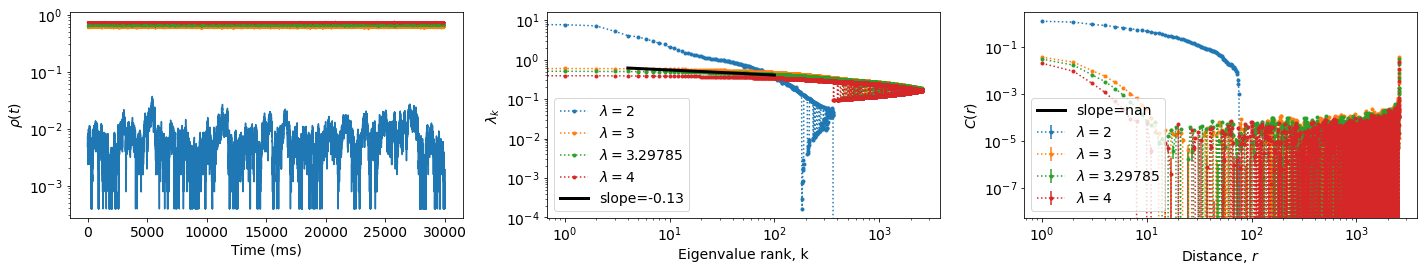

In [ ]:
plt.rcParams.update({'font.size':14})

n = 0

if os.path.exists(corr_data_file := f'test_sim/N{N}/corr_ring/corr_data_N{N}_lvalues_{get_lvalues_txt_for_save(l_values_all[n])}.mat'):
    print(' * Loading correlation data from file ... ')
    corr_data = scipy.io.loadmat(corr_data_file,squeeze_me=True)
    C_data[n]                = corr_data['C_data']
    lmbda_data[n]            = corr_data['lmbda_data']
    lmbda_dispersion_data[n] = corr_data['lmbda_dispersion_data']
    eigenvectors_data[n]     = corr_data['eigenvectors_data']
    V_matrix_data[n]         = corr_data['V_matrix_data']
    s_data[n]                = corr_data['s_data']
    Cf_data[n]               = corr_data['Cf_data']
    Cf_std_data[n]           = corr_data['Cf_std_data']
    d_info[n]                = io.recarray_to_structtype(corr_data['d_info'])
else:
    if not(nettype[n] in data_to_process):
        raise SystemExit(' * Data not processed... Include the Ring net data in the "data_to_process" variable and re-run previous cell.')


if corr:
    del corr
    del sys.modules['modules.correlation']
import modules.correlation as corr


lc_ind    = 2
lmbda     = lmbda_data[n][lc_ind]
k         = numpy.arange(lmbda.size) # eigenvalue rank
lmbda_fit = misc.linearized_fit(k, lmbda, numpy.log, numpy.log, numpy.exp, (k>10) & (k<300))

s       = s_data[n][lc_ind]
Cf      = Cf_data[n][lc_ind]
Cf_fit  = misc.linearized_fit(s,Cf,numpy.log,numpy.log,numpy.exp,(s>=1)&(s<=N/2))


fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,4))

for k,d in enumerate(d_info[n]):
    lmbda  = lmbda_data[n][k] * (1.0 if d.l >= 3.0 else 1e1) # rescaling subcritical data for better view
    s      = s_data[n][k]
    Cf     = Cf_data[n][k]    * (1.0 if d.l >= 3.0 else 5e2) # rescaling subcritical data for better view
    Cf_std = Cf_std_data[n][k]
    ax[0].plot(d.time,d.rho,'-',label=f'$\\lambda={d.l:g}$')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('$\\rho(t)$')
    ax[1].plot(numpy.arange(lmbda.size),lmbda,':.',label=f'$\\lambda={d.l:g}$')
    #ax[1].set_xlim((1.0,1e3))
    #ax[1].set_ylim((1e-1,1.5e1))
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Eigenvalue rank, k')
    ax[1].set_ylabel('$\\lambda_k$')
    ax[2].errorbar(s,Cf,Cf_std,fmt=':.',label=f'$\\lambda={d.l:g}$')
    #ax[2].set_xlim((1e-3,1))
    #ax[2].set_ylim((2e-3,1.5e-1))
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    ax[2].set_xlabel('Distance, $r$')
    ax[2].set_ylabel('$C(r)$')

k_fit = numpy.linspace(4,100,10)
r_fit = numpy.linspace(1,N/2,10)
ax[1].plot(k_fit,lmbda_fit.func(k_fit,*lmbda_fit.fitpar),'-k',linewidth=3,zorder=1000,label=f'slope={lmbda_fit.fitpar[0]:.2g}')
ax[2].plot(r_fit,   Cf_fit.func(r_fit,   *Cf_fit.fitpar),'-k',linewidth=3,zorder=1000,label=f'slope={   Cf_fit.fitpar[0]:.2g}')

ax[1].legend()
ax[2].legend()

plt.tight_layout()
plt.show()


# Ring Network Free BC

 * Loading correlation data from file ... 


d:\Dropbox\p\uottawa\programs\python\contact_process\modules\correlation.py:719: RuntimeWarning: divide by zero encountered in log
  func  = lambda x,*fitpar: inverse_transform(fitpar[0] * x_transform(x) + fitpar[1])
d:\Dropbox\p\uottawa\programs\python\contact_process\modules\correlation.py:709: RuntimeWarning: invalid value encountered in log
  y_lin = y_transform(y_data[mask])


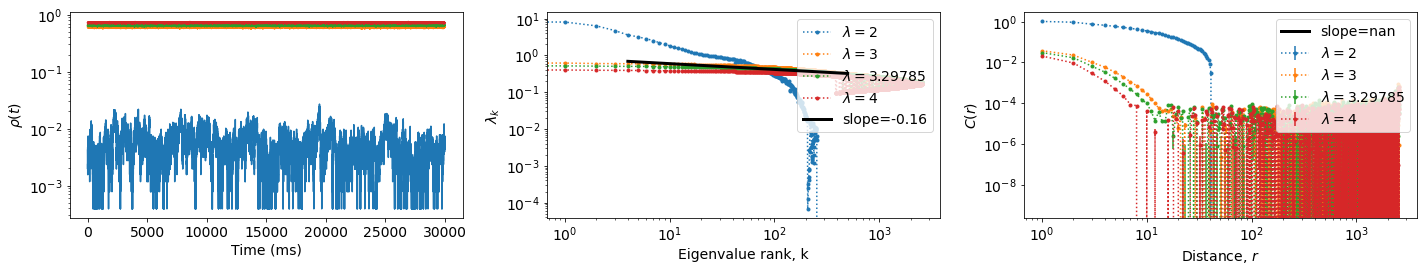

In [ ]:
plt.rcParams.update({'font.size':14})

n = 1
if os.path.exists(corr_data_file := f'test_sim/N{2560}/corr_ringf/corr_data_N{N}_lvalues_{get_lvalues_txt_for_save(l_values_all[n])}.mat'):
    print(' * Loading correlation data from file ... ')
    corr_data = scipy.io.loadmat(corr_data_file,squeeze_me=True)
    C_data[n]                = corr_data['C_data']
    lmbda_data[n]            = corr_data['lmbda_data']
    lmbda_dispersion_data[n] = corr_data['lmbda_dispersion_data']
    eigenvectors_data[n]     = corr_data['eigenvectors_data']
    V_matrix_data[n]         = corr_data['V_matrix_data']
    s_data[n]                = corr_data['s_data']
    Cf_data[n]               = corr_data['Cf_data']
    Cf_std_data[n]           = corr_data['Cf_std_data']
    d_info[n]                = io.recarray_to_structtype(corr_data['d_info'])
else:
    if not(nettype[n] in data_to_process):
        raise SystemExit(' * Data not processed... Include the "Ring Free BC" net data in the "data_to_process" variable and re-run previous cell.')


if corr:
    del corr
    del sys.modules['modules.correlation']
import modules.correlation as corr


lc_ind    = 2
lmbda     = lmbda_data[n][lc_ind]
k         = numpy.arange(lmbda.size) # eigenvalue rank
lmbda_fit = misc.linearized_fit(k, lmbda, numpy.log, numpy.log, numpy.exp, (k>4e1) & (k<3e2))

s       = s_data[n][lc_ind]
Cf      = Cf_data[n][lc_ind]
Cf_fit  = misc.linearized_fit(s,Cf,numpy.log,numpy.log,numpy.exp,(s>=10)&(s<=1e2))


fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,4))

for k,d in enumerate(d_info[n]):
    lmbda  = lmbda_data[n][k] * (1.0 if d.l >= 3.0 else 1e1) # rescaling subcritical data for better view
    s      = s_data[n][k]
    Cf     = Cf_data[n][k]    * (1.0 if d.l >= 3.0 else 5e2) # rescaling subcritical data for better view
    Cf_std = Cf_std_data[n][k]
    ax[0].plot(d.time,d.rho,'-',label=f'$\\lambda={d.l:g}$')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('$\\rho(t)$')
    ax[1].plot(numpy.arange(lmbda.size),lmbda,':.',label=f'$\\lambda={d.l:g}$')
    #ax[1].set_xlim((1.0,1e3))
    #ax[1].set_ylim((1e-1,1.5e1))
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Eigenvalue rank, k')
    ax[1].set_ylabel('$\\lambda_k$')
    ax[2].errorbar(s,Cf,Cf_std,fmt=':.',label=f'$\\lambda={d.l:g}$')
    #ax[2].set_xlim((0.8,1e3))
    #ax[2].set_ylim((2e-3,1.5e-1))
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    ax[2].set_xlabel('Distance, $r$')
    ax[2].set_ylabel('$C(r)$')

k_fit = numpy.linspace(4,5e2,10)
r_fit = numpy.linspace(1,3e2,10)
ax[1].plot(k_fit,lmbda_fit.func(k_fit,*lmbda_fit.fitpar),'-k',linewidth=3,zorder=1000,label=f'slope={lmbda_fit.fitpar[0]:.2g}')
ax[2].plot(r_fit,   Cf_fit.func(r_fit,   *Cf_fit.fitpar),'-k',linewidth=3,zorder=1000,label=f'slope={   Cf_fit.fitpar[0]:.2g}')

ax[1].legend(bbox_to_anchor=(1,1),loc='upper right')
ax[2].legend(bbox_to_anchor=(1,1),loc='upper right')

plt.tight_layout()
plt.show()


# Mean-field network

 * Loading correlation data from file ... 


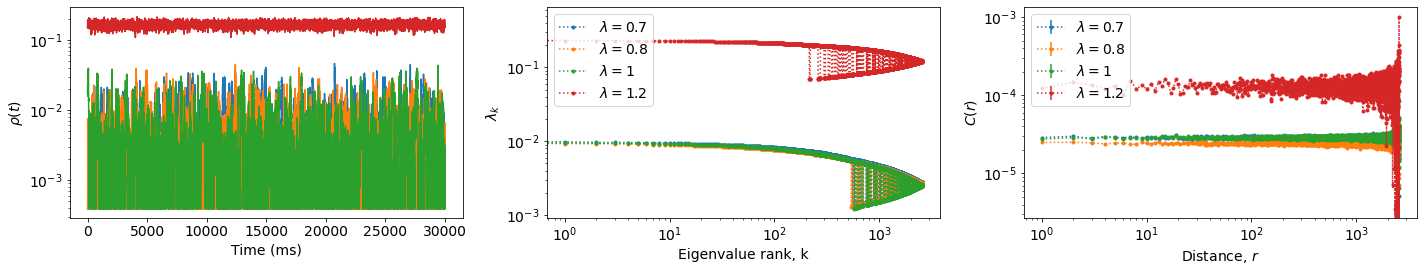

In [ ]:
n = 2

if os.path.exists(corr_data_file := f'test_sim/N{N}/corr_mf/corr_data_N{N}_lvalues_{get_lvalues_txt_for_save(l_values_all[n])}.mat'):
    print(' * Loading correlation data from file ... ')
    corr_data = scipy.io.loadmat(corr_data_file,squeeze_me=True)
    C_data[n]                = corr_data['C_data']
    lmbda_data[n]            = corr_data['lmbda_data']
    lmbda_dispersion_data[n] = corr_data['lmbda_dispersion_data']
    eigenvectors_data[n]     = corr_data['eigenvectors_data']
    V_matrix_data[n]         = corr_data['V_matrix_data']
    s_data[n]                = corr_data['s_data']
    Cf_data[n]               = corr_data['Cf_data']
    Cf_std_data[n]           = corr_data['Cf_std_data']
    d_info[n]                = io.recarray_to_structtype(corr_data['d_info'])
else:
    if not(nettype[n] in data_to_process):
        raise SystemExit(' * Data not processed... Include the "Mean-field" net data in the "data_to_process" variable and re-run previous cell.')

plt.rcParams.update({'font.size':14})

if corr:
    del corr
    del sys.modules['modules.correlation']
import modules.correlation as corr


#lc_ind    = 1
#lmbda     = lmbda_data[n][lc_ind]
#k         = numpy.arange(lmbda.size) # eigenvalue rank
#lmbda_fit = misc.linearized_fit(k, lmbda, numpy.log, numpy.log, numpy.exp, (k>10) & (k<300))
#
#s       = s_data[n][lc_ind]
#Cf      = Cf_data[n][lc_ind]
#Cf_fit  = misc.linearized_fit(s,Cf,numpy.log,numpy.log,numpy.exp,(s>=2e-3)&(s<=5e-2))


fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,4))

for k,d in enumerate(d_info[n]):
    lmbda  = lmbda_data[n][k]# * (1.0 if d.l >= 3.0 else 1e1) # rescaling subcritical data for better view
    s      = s_data[n][k]
    Cf     = Cf_data[n][k]    #* (1.0 if d.l >= 3.0 else 5e2) # rescaling subcritical data for better view
    Cf_std = Cf_std_data[n][k]
    ax[0].plot(d.time,d.rho,'-',label=f'$\\lambda={d.l:g}$')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_ylabel('$\\rho(t)$')
    ax[1].plot(numpy.arange(lmbda.size),lmbda,':.',label=f'$\\lambda={d.l:g}$')
    #######ax[1].set_xlim((1.0,1e3))
    #######ax[1].set_ylim((1e-1,1.5e1))
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Eigenvalue rank, k')
    ax[1].set_ylabel('$\\lambda_k$')
    ax[2].errorbar(s,Cf,Cf_std,fmt=':.',label=f'$\\lambda={d.l:g}$')
    ######ax[2].set_xlim((1e-3,1))
    ######ax[2].set_ylim((2e-3,1.5e-1))
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    ax[2].set_xlabel('Distance, $r$')
    ax[2].set_ylabel('$C(r)$')

#k_fit = numpy.linspace(4,100,10)
#r_fit = numpy.linspace(2e-3,1e-1,10)
#ax[1].plot(k_fit,lmbda_fit.func(k_fit,*lmbda_fit.fitpar),'-k',linewidth=3,zorder=1000,label=f'slope={lmbda_fit.fitpar[0]:.2g}')
#ax[2].plot(r_fit,   Cf_fit.func(r_fit,   *Cf_fit.fitpar),'-k',linewidth=3,zorder=1000,label=f'slope={   Cf_fit.fitpar[0]:.2g}')

ax[1].legend()
ax[2].legend()

plt.tight_layout()
plt.show()


# Tests

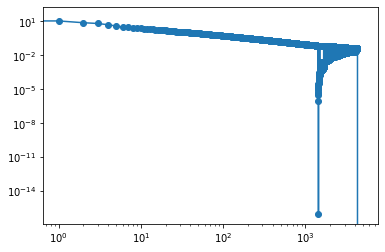

In [2]:
plt.plot(numpy.arange(lmbda.size),lmbda,'-o')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [11]:
# reloading modules
if corr:
    del corr
    del sys.modules['modules.correlation']
import modules.correlation as corr

s,Cf,Cf_std = corr.calc_correlation_function_1d_periodic(C,True)

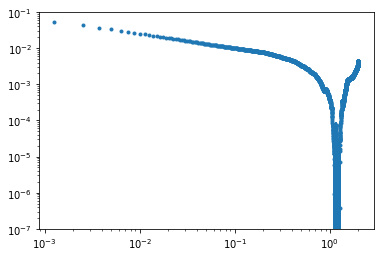

In [13]:
plt.errorbar(s,Cf,Cf_std,fmt='.')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [16]:
numpy.linspace(0,5,5)

array([0.  , 1.25, 2.5 , 3.75, 5.  ])

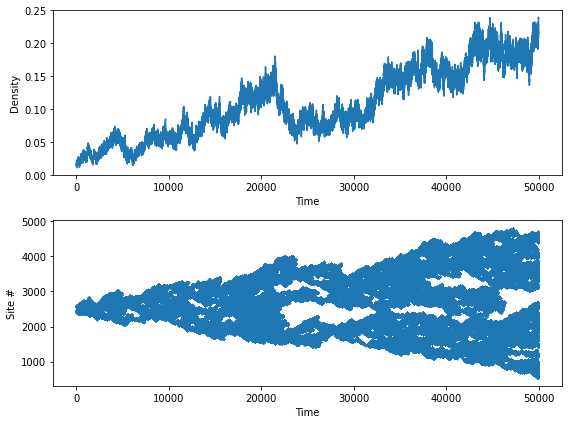

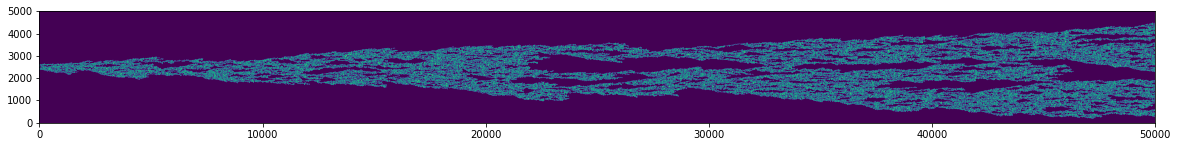

In [ ]:
import sys
import modules.io as io
import matplotlib.pyplot as plt

import modules.correlation as corr
# reloading modules
if corr:
    del corr
    del sys.modules['modules.correlation']
import modules.correlation as corr

d = io.import_mat_file('test_sim/N5000/corr_ring/cp_ring_l3.0_par_aval_N5000_t50000_fX00.mat')

S = corr.spike_times_to_spiketrain(d.X_time,d.X_ind,X=d.X_values,N=d.N)
#C = corr.calc_correlation_matrices()

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,6))

ax[0].plot(d.time,d.rho,'-')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Density')

ax[1].scatter(d.X_time, d.X_ind, s=0.01)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Site #')

plt.tight_layout()

fig2,ax2 = plt.subplots(nrows=1,ncols=1,figsize=(20,5))
ax2.imshow(S.T,extent=[0,50000,0,5000])

plt.show()


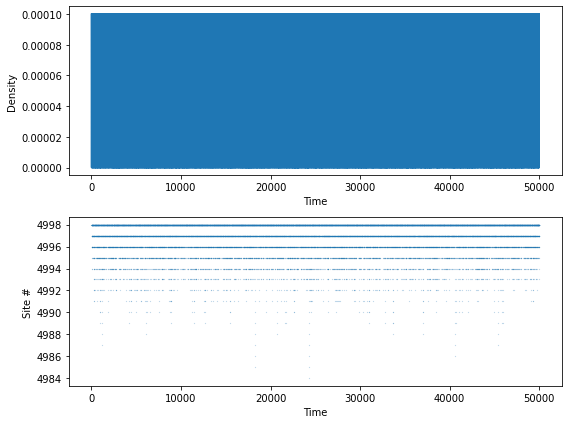

In [4]:
import modules.io as io
import matplotlib.pyplot as plt

d = io.import_mat_file('test_sim_corr/cp_ring_l1.0_par_aval_N10000_t50000_fX00.mat')
#print(d)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,6))

ax[0].plot(d.time,d.rho,'-')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Density')
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')

ax[1].scatter(d.X_time, d.X_ind, s=0.01)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Site #')
#ax[1].set_xscale('log')

plt.tight_layout()

plt.show()


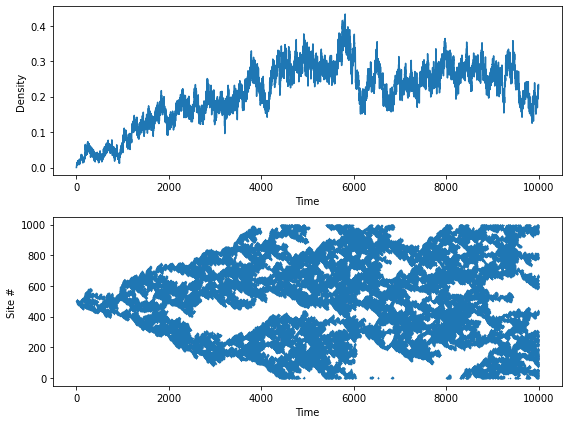

In [4]:
import modules.io as io
import matplotlib.pyplot as plt

d = io.import_mat_file('test_sim_corr/cp_ring_l3.0_aval_N1000_t10000_fX00.mat')
#print(d)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,6))

ax[0].plot(d.time,d.rho,'-')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Density')
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')

ax[1].scatter(d.X_time, d.X_ind, s=0.01)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Site #')
#ax[1].set_xscale('log')

plt.tight_layout()

plt.show()


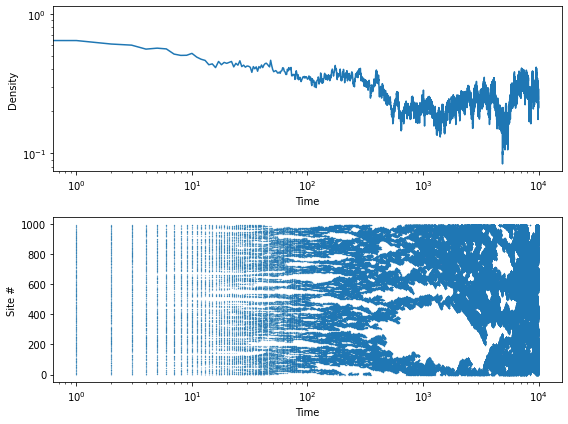

In [17]:
import modules.io as io
import matplotlib.pyplot as plt

d = io.import_mat_file('test_sim_results/cp_ring_l3.0_aval_N1000_t10000_fX01.mat')
#print(d)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,6))

ax[0].plot(d.time,d.rho,'-')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Density')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].scatter(d.X_time, d.X_ind, s=0.01)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Site #')
ax[1].set_xscale('log')

plt.tight_layout()

plt.show()


In [11]:
!python -OO contact_process.py -l 3.0 -N 1000 -tTotal 10000 -graph ring -X0 1 -outputFile cp_ring_l3.0_aval_N1000_t10000.mat -saveSites -writeOnRun

* Simulation parameters:
structtype(
                   M: 100
                   N: 1000
                  X0: 1
              X0Rand: True
                  dt: 0.001
          expandtime: True
                 fX0: 0.5
               graph: 'ring'
                   l: 3.0
            noX0Rand: False
          outputFile: 'cp_ring_l3.0_aval_N1000_t10000.mat'
           saveSites: True
                 sim: 'timeevo'
         spkFileName: 'cp_ring_l3.0_aval_N1000_t10000_spk.txt'
              tTotal: 10000
              tTrans: 0
              update: 'seq'
          writeOnRun: True
)
* Running simulation... Total time steps = 10000000
spk file opened: cp_ring_l3.0_aval_N1000_t10000_spk.txt
spk file close
* End of simulation... Total time: 0:01:39.204000
* Writing ... cp_ring_l3.0_aval_N1000_t10000.mat
done
 


In [1]:
import modules.io as io

io.merge_simulation_files('cp_ring_l3.0_aval_N1000_t10000.mat', remove_spk_file=False, verbose=True)

Merging files: cp_ring_l3.0_aval_N1000_t10000.mat and cp_ring_l3.0_aval_N1000_t10000_spk.txt
  ... spk file {spkFileName} was written and loaded successfully
 ... merged file saved as cp_ring_l3.0_aval_N1000_t10000.mat


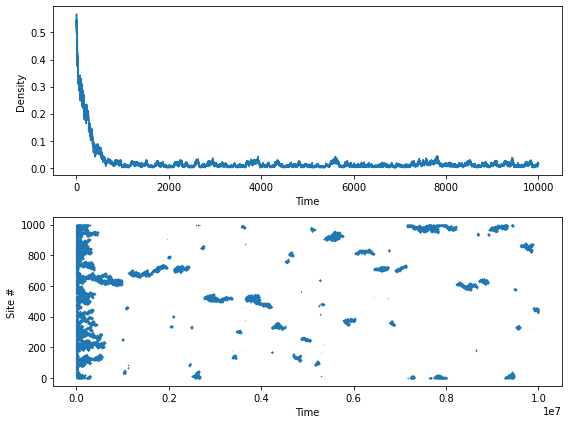

In [14]:
import modules.io as io
import matplotlib.pyplot as plt

d = io.import_mat_file('test_sim_results/cp_ring_l3.0_aval_N1000_t10000_1.mat')
#print(d)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,6))

ax[0].plot(d.time,d.rho,'-')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Density')

ax[1].scatter(d.X_time, d.X_ind, s=0.01)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Site #')

plt.tight_layout()

plt.show()


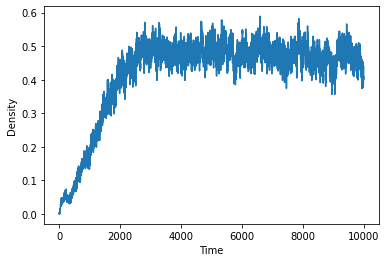

In [ ]:
import modules.io as io
import matplotlib.pyplot as plt

d = io.import_mat_file('test_sim_results/cp_ring_l3.297_aval_N1000_t10000.mat')
plt.plot(d.time,d.rho,'-')
plt.xlabel('Time')
plt.ylabel('Density')
plt.show()


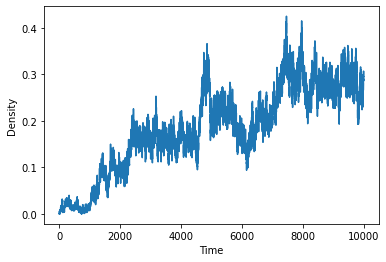

In [13]:

d = io.import_mat_file('test_sim_results/cp_ring_l3.0_aval_N1000_t10000.mat')
plt.plot(d.time,d.rho,'-')
plt.xlabel('Time')
plt.ylabel('Density')
plt.show()
